This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_sir
from stochastic_tests import Test
import stochastic_repro as sr

pd.set_option('display.max_rows', None)

t_fin = 10.0
num_steps = 100
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000]
                   )

beta1_mean = 2.0E-6
beta2_mean = 3.0E-6

test1 = Test(model=model_sir({'beta': ('norm', (beta1_mean, beta1_mean / 10))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_sir({'beta': ('norm', (beta2_mean, beta2_mean / 10))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

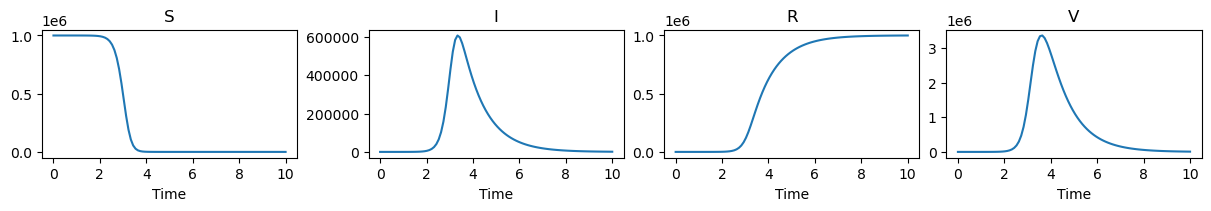

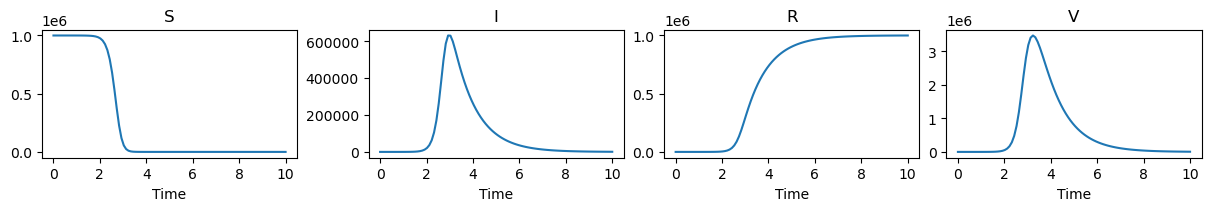

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

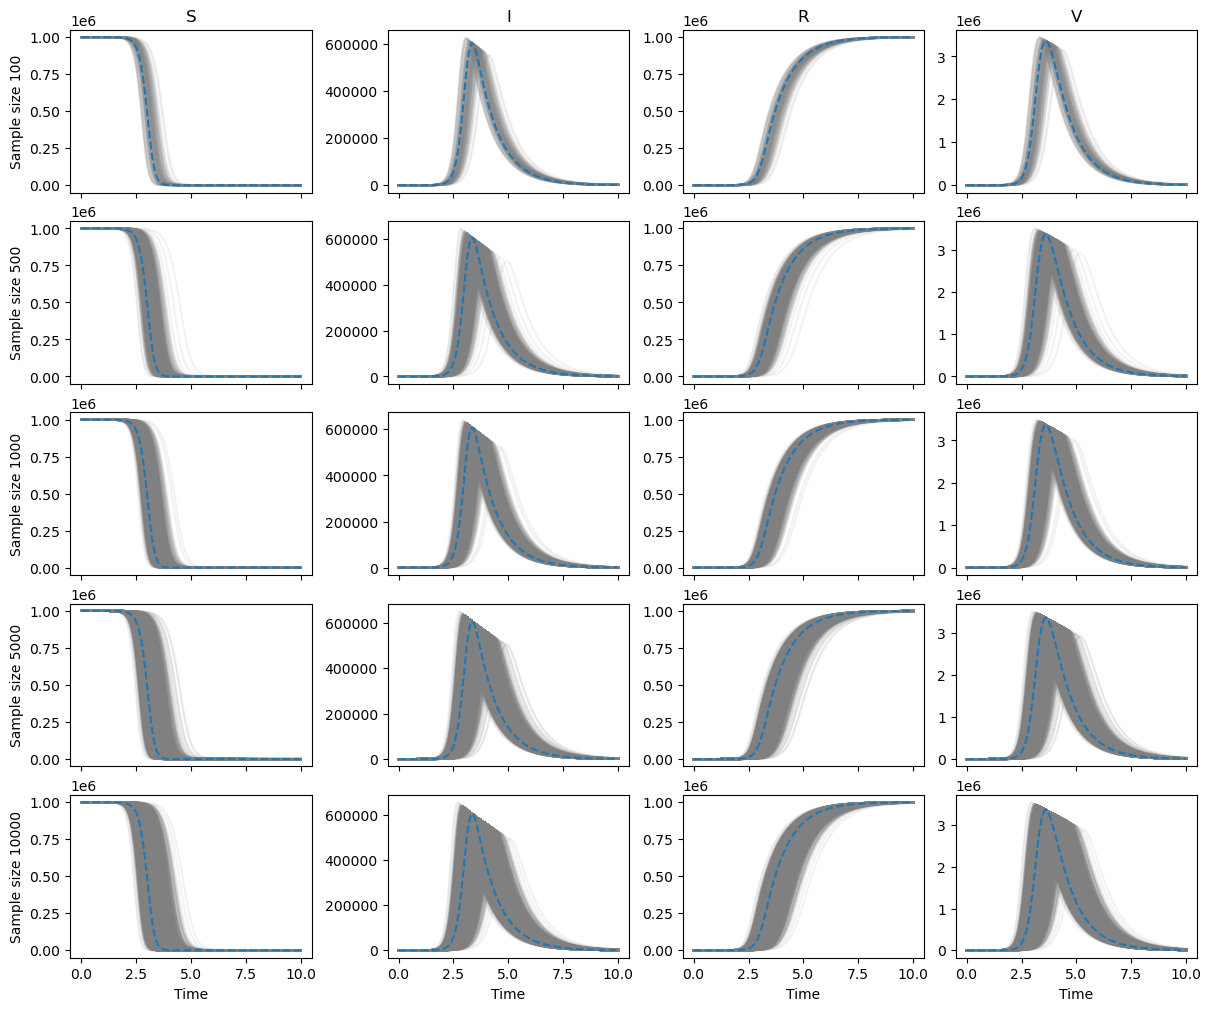

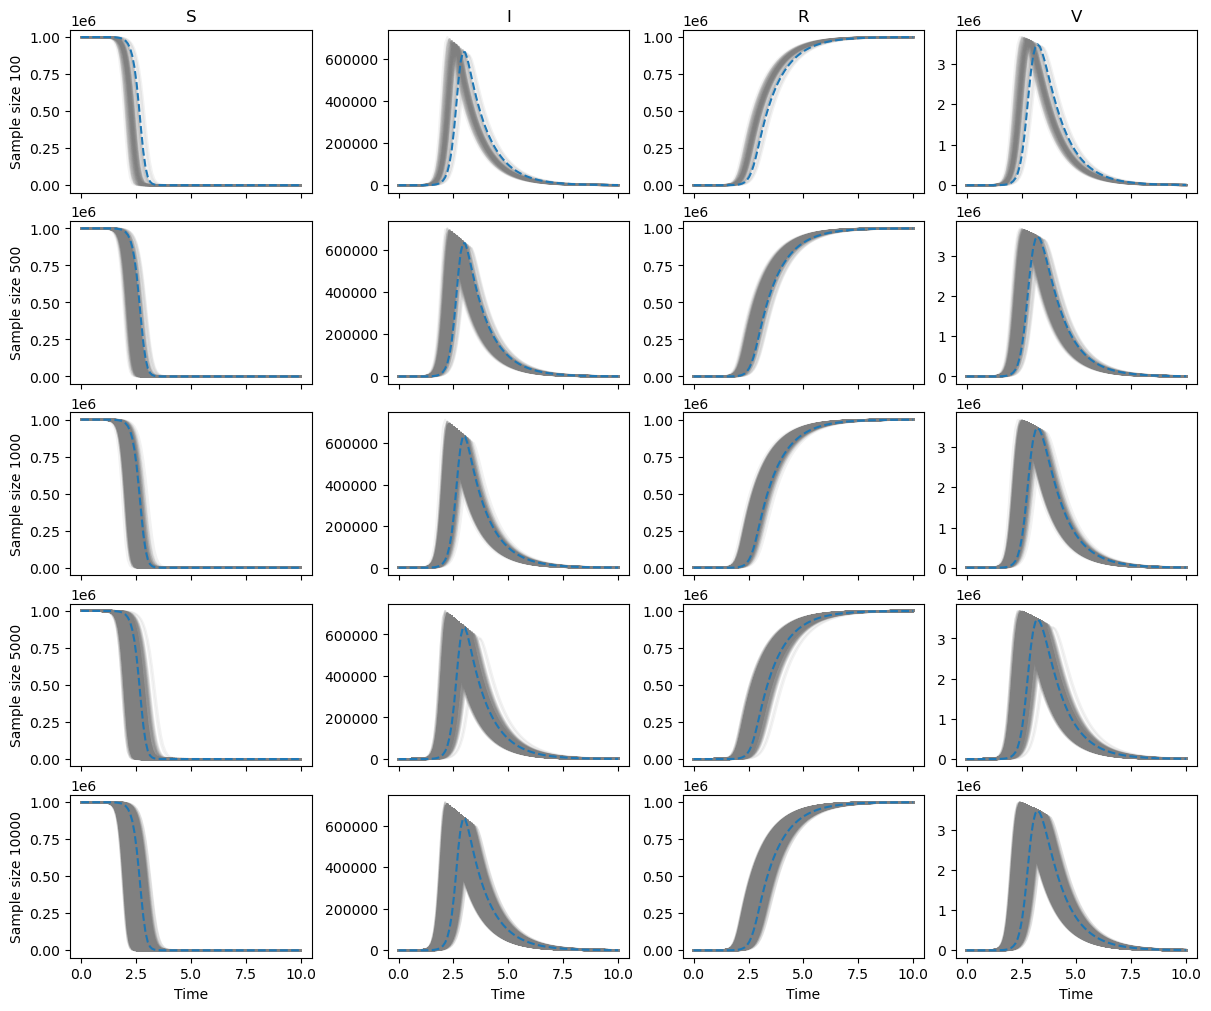

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

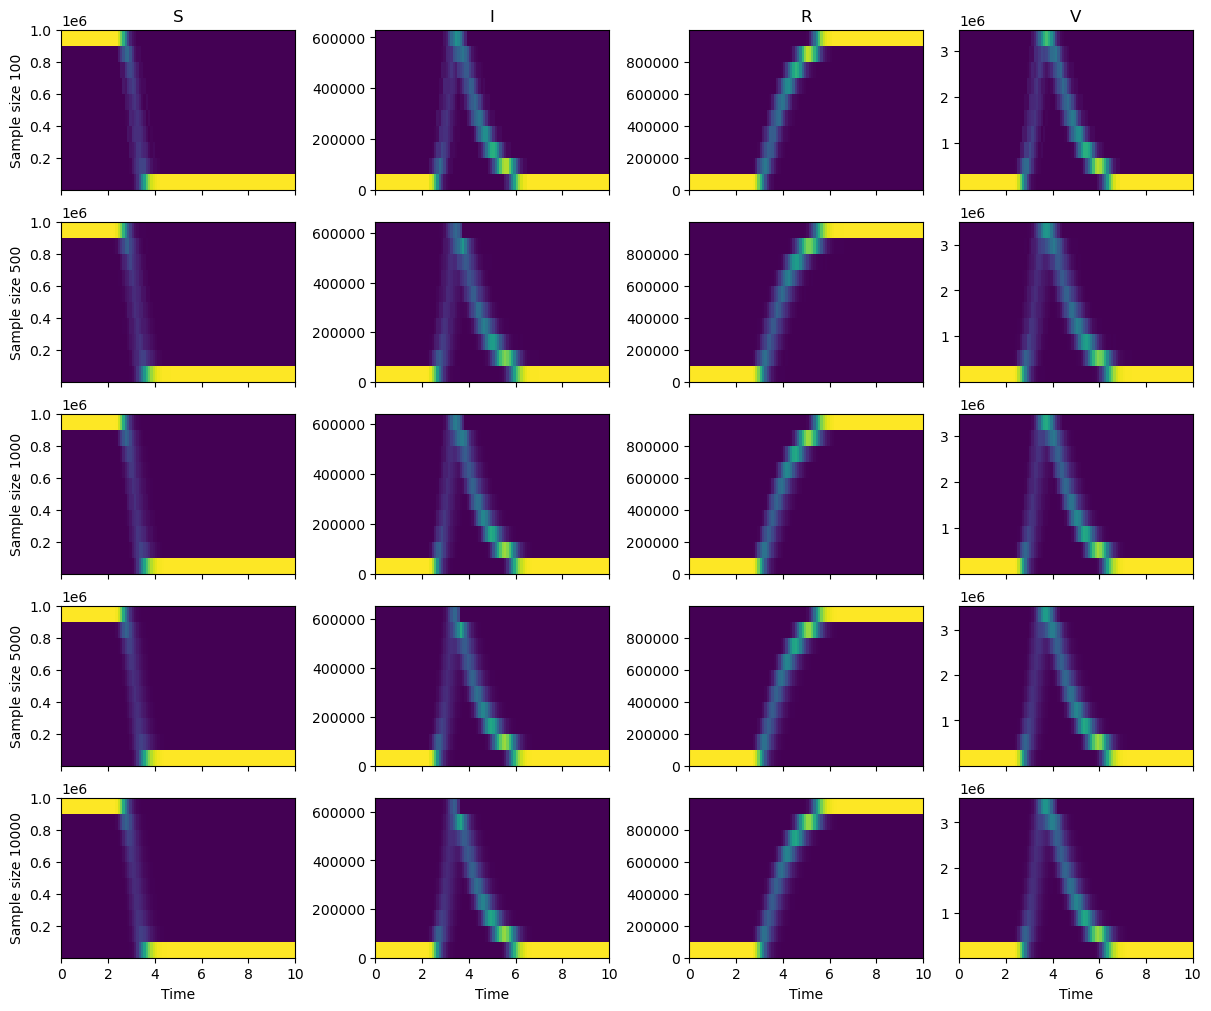

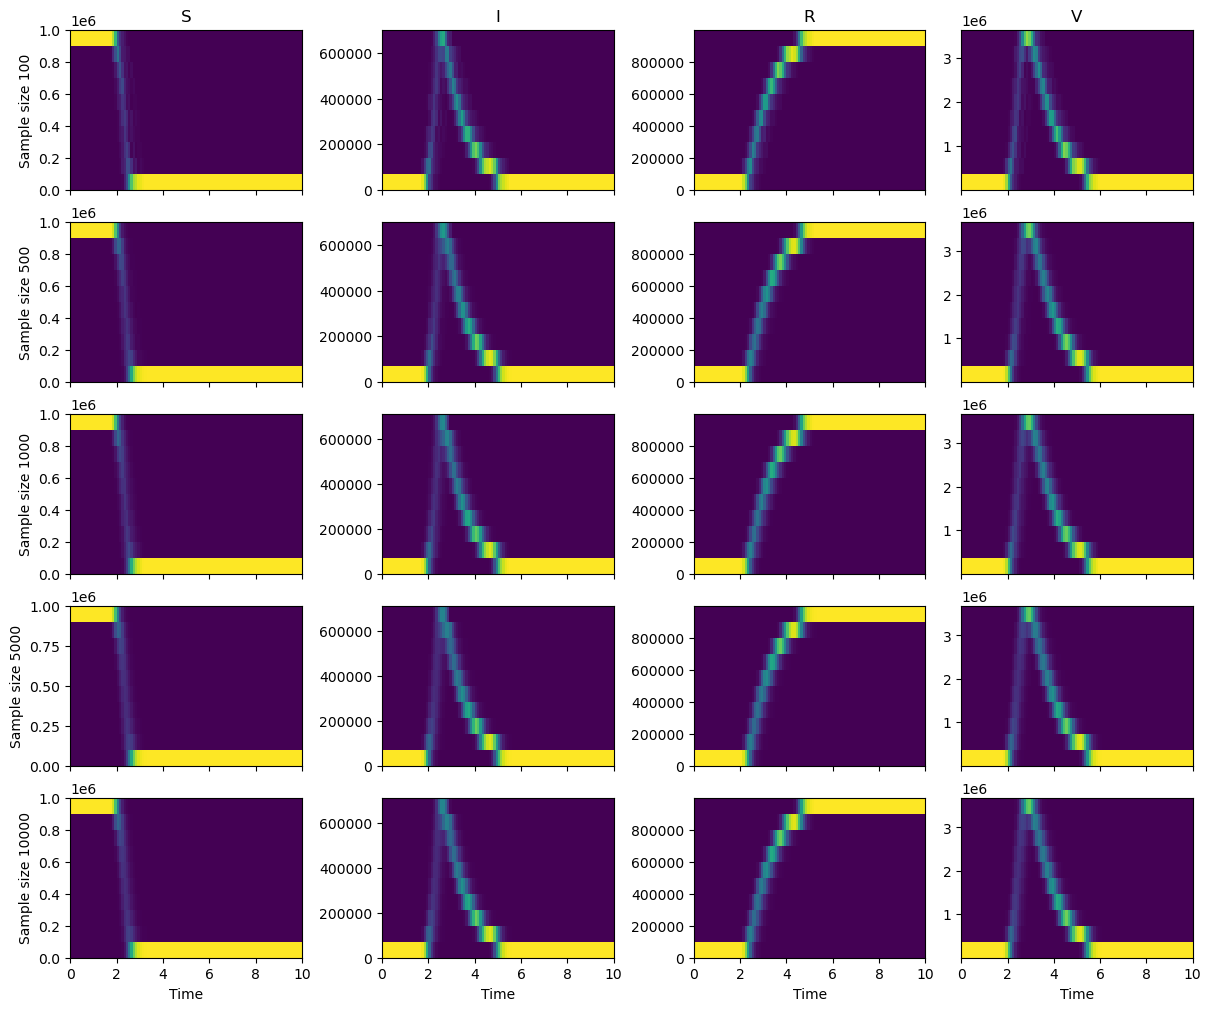

In [5]:
for test in tests:
    _ = test.plot_distributions()

C:\Users\timothy.sego\AppData\Local\miniconda3\envs\stoch_repro\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


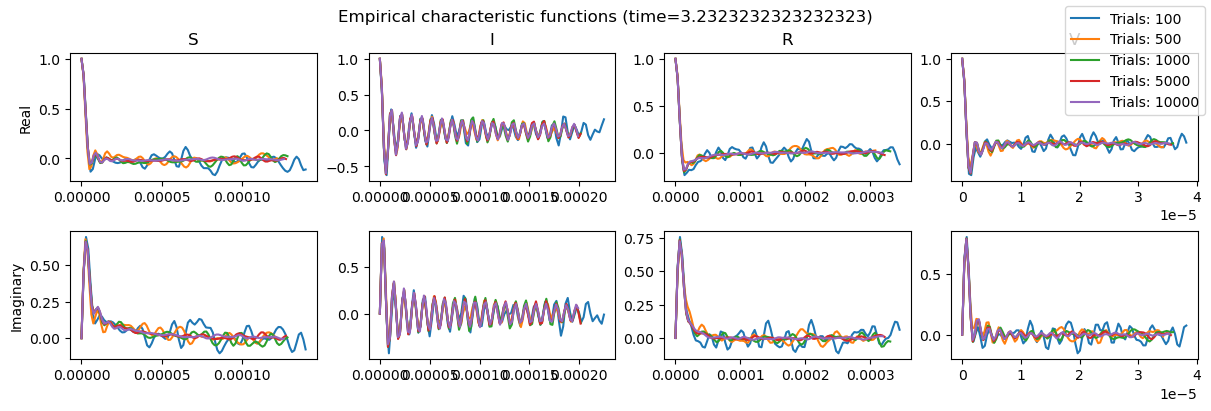

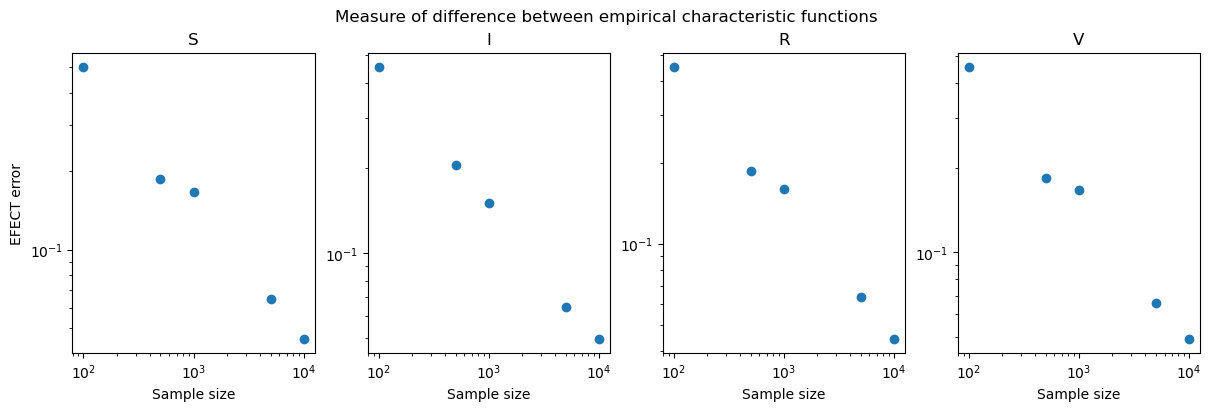

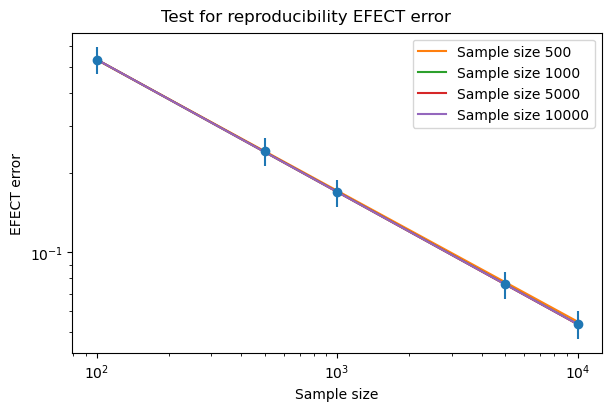

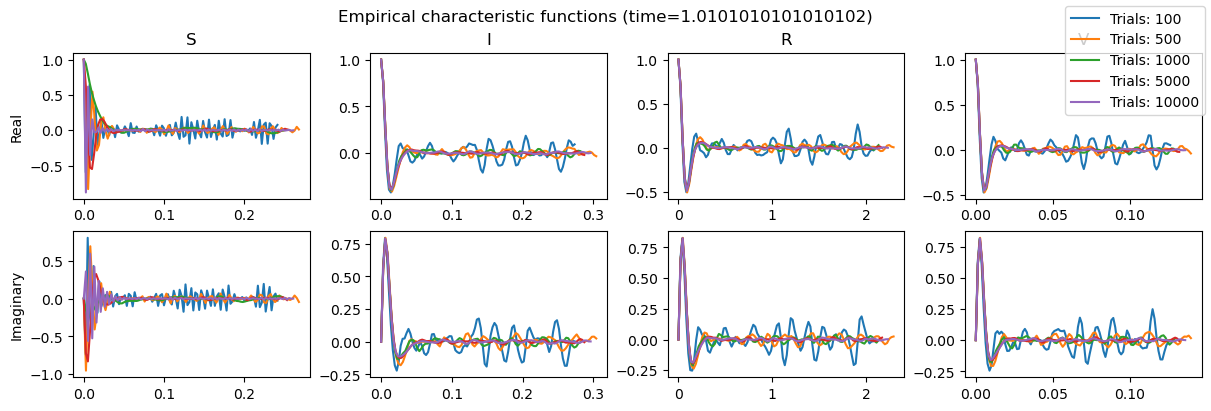

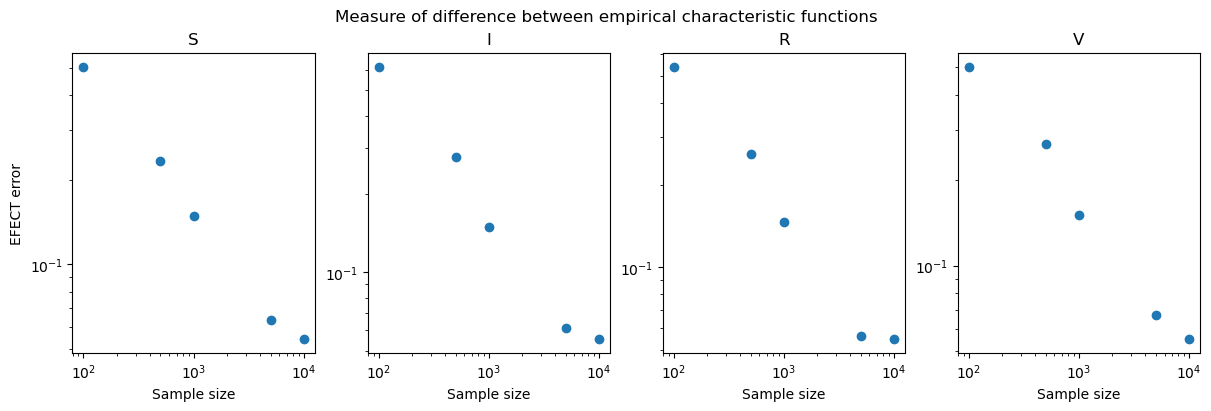

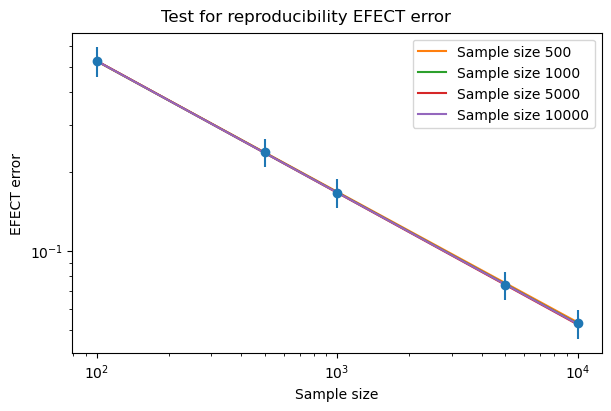

In [6]:
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

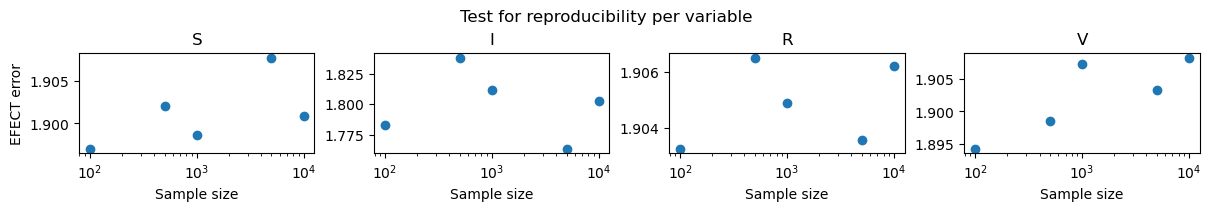

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('Sample size')
    ax[i].set_xscale('log')
    ax[i].set_title(name)
ax[0].set_ylabel('EFECT error')
_ = fig.suptitle('Test for reproducibility per variable')

Testing for how well the method can detect differences in model parameters. 

Output()

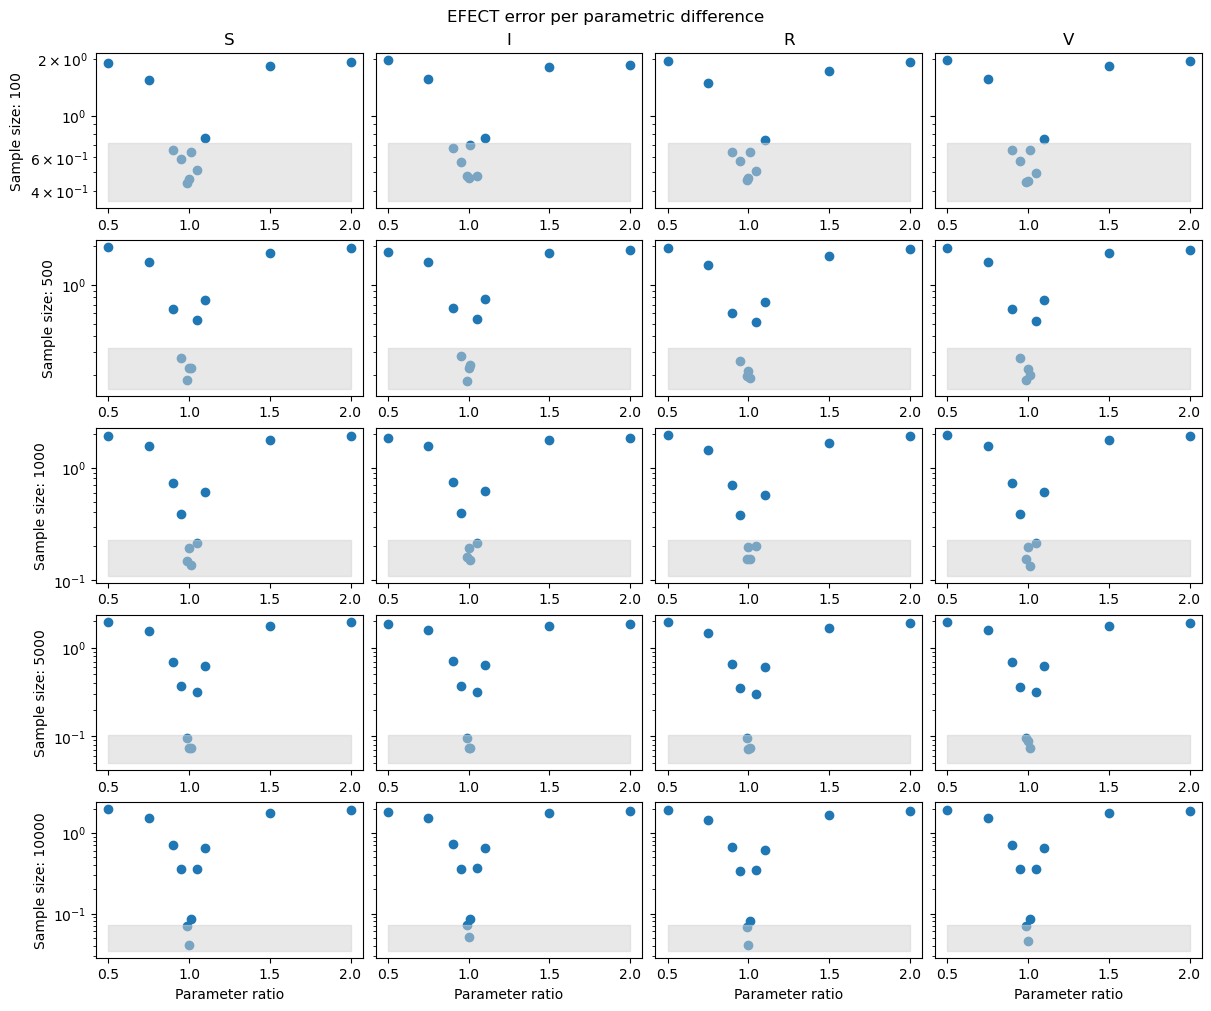

In [8]:
beta_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
beta_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for bf in beta_fact:
    label.value = f'Factor: {bf}...'

    betatest_mean = beta1_mean * bf
    test = Test(model=model_sir({'beta': ('norm', (betatest_mean, betatest_mean / 10))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    beta_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(beta_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in beta_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(beta_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('EFECT error per parametric difference')

Report stats on detecting differences.

An upper bound on the probability of a false-positive when testing for reproducing results is calculated using Chebyshev's inequality with unknown population mean and variance. See equation 17 from 10.1007/s11222-011-9229-0. 

In [9]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'EFECT error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in beta_comp]
    q2 = (sample_size + 1) / sample_size * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / l2 + 1)) / (sample_size + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(beta_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.534478,0.060808
500,0.241157,0.02822
1000,0.168768,0.019776
5000,0.075735,0.008813
10000,0.053691,0.006372


Sample size  \
Sample size Scaling factor EFECT error Standardized error Acceptance p-value                
100         0.50           1.967153     23.560792         0.019608                    100   
            0.75           1.561477     16.889328         0.019608                    100   
            0.90           0.674154     2.297029          0.196078                    100   
            0.95           0.588403     0.886823          1.000000                    100   
            0.99           0.481404    -0.872808          1.000000                    100   
            1.00           0.467389    -1.103289          1.000000                    100   
            1.01           0.694845     2.637287          0.156863                    100   
            1.05           0.513679    -0.342043          1.000000                    100   
            1.10           0.764622     3.784796          0.078431                    100   
            1.50           1.826229     21.243255         0.019608                    100   
            2.00           1.940577     23.123740         0.019608                    100   
500         0.50           1.949997     60.555146         0.003984                    500   
            0.75           1.509278     44.937628         0.003984                    500   
            0.90           0.660470     14.858942         0.007968                    500   
            0.95           0.280570     1.396637          0.513944                    500   
            0.99           0.195760    -1.608710          1.000000                    500   
            1.00           0.226649    -0.514118          1.000000                    500   
            1.01           0.240252    -0.032101          1.000000                    500   
            1.05           0.540190     10.596642         0.011952                    500   
            1.10           0.777072     18.990872         0.003984                    500   
            1.50           1.779615     54.517410         0.003984                    500   
            2.00           1.945260     60.387276         0.003984                    500   
1000        0.50           1.951258     90.135742         0.001996                   1000   
            0.75           1.551363     69.914126         0.001996                   1000   
            0.90           0.737880     28.778444         0.001996                   1000   
            0.95           0.395059     11.442900         0.007984                   1000   
            0.99           0.159648    -0.461194          1.000000                   1000   
            1.00           0.195782     1.366032          0.538922                   1000   
            1.01           0.155182    -0.687026          1.000000                   1000   
            1.05           0.215055     2.340622          0.183633                   1000   
            1.10           0.615342     22.582065         0.001996                   1000   
            1.50           1.759343     80.431102         0.001996                   1000   
            2.00           1.909817     88.040210         0.001996                   1000   
5000        0.50           1.955341     213.274311        0.000400                   5000   
            0.75           1.580455     170.736983        0.000400                   5000   
            0.90           0.705442     71.451340         0.000400                   5000   
            0.95           0.374362     33.884467         0.001200                   5000   
            0.99           0.094941     2.179332          0.211515                   5000   
            1.00           0.088403     1.437480          0.485806                   5000   
            1.01           0.074183    -0.176086          1.000000                   5000   
            1.05           0.315941     27.255639         0.001599                   5000   
            1.10           0.639770     63.999722         0.000400             